In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import os

import json
import gzip

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from network.model import NerFormer
from network.feature_network import FeatureNet
from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from co3d_utils import *

In [3]:
from typing import Union, IO, Any, List, Tuple, Optional
import typing

In [3]:
frame_annotations_file = "test_dataset/frame_annotations.jgz"
frame_zipfile = gzip.open(frame_annotations_file, "rt", encoding="utf8")

frame_dicts = json.load(frame_zipfile)
print(type(frame_dicts), len(frame_dicts))

sequence_annotations_file = "test_dataset/sequence_annotations.jgz"
seq_zipfile = gzip.open(sequence_annotations_file, "rt", encoding="utf8")

seq_dicts = json.load(seq_zipfile)
print(type(seq_dicts), len(seq_dicts))

<class 'list'> 72865
<class 'list'> 749


In [4]:
# test dataset sequence : 5016
print(seq_dicts[13])

{'sequence_name': '38_1655_5016', 'category': 'teddybear', 'video': {'path': 'teddybear/38_1655_5016/video.MOV', 'length': -1.0}, 'point_cloud': {'path': 'teddybear/38_1655_5016/pointcloud.ply', 'quality_score': -0.1287639368068927, 'n_points': 107456}, 'viewpoint_quality_score': 1.5571424798893008}


In [6]:
sorted_seq_dicts = sorted(seq_dicts, key=lambda x : x["viewpoint_quality_score"], reverse=True)

for i in range(0, 5):
    print(sorted_seq_dicts[i])
    print()

{'sequence_name': '288_30468_58729', 'category': 'teddybear', 'video': {'path': 'teddybear/288_30468_58729/video.mp4', 'length': -1.0}, 'point_cloud': {'path': 'teddybear/288_30468_58729/pointcloud.ply', 'quality_score': 1.1844415792980882, 'n_points': 980001}, 'viewpoint_quality_score': 1.7614576166030769}

{'sequence_name': '377_43542_86729', 'category': 'teddybear', 'video': {'path': 'teddybear/377_43542_86729/video.mp4', 'length': -1.0}, 'point_cloud': {'path': 'teddybear/377_43542_86729/pointcloud.ply', 'quality_score': 0.9462855108486599, 'n_points': 411946}, 'viewpoint_quality_score': 1.760524695401784}

{'sequence_name': '373_41666_83167', 'category': 'teddybear', 'video': {'path': 'teddybear/373_41666_83167/video.mp4', 'length': -1.0}, 'point_cloud': {'path': 'teddybear/373_41666_83167/pointcloud.ply', 'quality_score': 1.150575320531984, 'n_points': 648217}, 'viewpoint_quality_score': 1.7523144448511043}

{'sequence_name': '375_42776_85717', 'category': 'teddybear', 'video': {

In [7]:
# test dataset image : 1323 ~ 1332
data_dicts = frame_dicts[1323:1333]
print(data_dicts[0], '\n\n', data_dicts[-1])

print('\n\n', data_dicts[0].keys())
print('\n', data_dicts[0]['viewpoint'])

{'sequence_name': '38_1655_5016', 'frame_number': 0, 'frame_timestamp': -1.0, 'image': {'path': 'teddybear/38_1655_5016/images/frame000001.jpg', 'size': [479, 359]}, 'depth': {'path': 'teddybear/38_1655_5016/depths/frame000001.jpg.geometric.png', 'scale_adjustment': 1.262808918952942, 'mask_path': 'teddybear/38_1655_5016/depth_masks/frame000001.png'}, 'mask': {'path': 'teddybear/38_1655_5016/masks/frame000001.png', 'mass': 35984.0}, 'viewpoint': {'R': [[-0.9965706467628479, 0.004121924750506878, 0.08264364302158356], [-0.006493818014860153, -0.9995740652084351, -0.028452031314373016], [0.08249115943908691, -0.028891131281852722, 0.9961729049682617]], 'T': [0.20043912529945374, 1.2990046739578247, 6.429634094238281], 'focal_length': [2.1856130105871343, 1.6380690413377479], 'principal_point': [0.0, 0.0]}} 

 {'sequence_name': '38_1655_5016', 'frame_number': 9, 'frame_timestamp': -1.0, 'image': {'path': 'teddybear/38_1655_5016/images/frame000010.jpg', 'size': [480, 359]}, 'depth': {'path

In [10]:
def get_w2c_intrinsic(img_size, viewpoint):
    rotation = torch.tensor(viewpoint['R'])
    translation =  torch.tensor(viewpoint['T'])
    
    extrinsic = torch.eye(4)
    extrinsic[:3, :3] = rotation
    extrinsic[:3, 3] = translation
    
    w2c = extrinsic
    c2w = torch.inverse(w2c)
    
    focal_length =  torch.tensor(viewpoint["focal_length"])
    principal_point =  torch.tensor(viewpoint["principal_point"])

    # principal point and focal length in pixels
    half_image_size_wh_orig = torch.tensor([x/2 for x in img_size])
    principal_point_px = -1.0 * (principal_point - 1.0) * half_image_size_wh_orig
    focal_length_px = focal_length * half_image_size_wh_orig
    # if self.box_crop:
    #     assert clamp_bbox_xyxy is not None
    #     principal_point_px -= clamp_bbox_xyxy[:2]

    # # rescaled principal point and focal length in ndc
    # principal_point = 1 - principal_point_px * scale / half_image_size_wh_output
    # focal_length = focal_length_px * scale / half_image_size_wh_output

    intrinsic = torch.eye(4)
    intrinsic[0][2], intrinsic[1][2] = principal_point_px
    intrinsic[0][0], intrinsic[1][1] = focal_length_px

    return c2w, intrinsic

    
def read_seq_data(seq_path):
    frame_annotations_file = os.path.join(seq_path, "frame_annotations_file.json")
    with open(frame_annotations_file, 'r') as f:
        frames = json.load(f)

    seq_imgs = []
    seq_c2w_mats = []        # extrinsics
    seq_intrinsic_mats = []

    translation_bd = float("-inf")
    for frame in frames:
        seq_imgs.append(frame["image"]["path"])
        
        c2w, intrinsic = get_w2c_intrinsic(frame["image"]["size"], frame["viewpoint"])
        
        bd = torch.abs(c2w[:3, 3]).max()
        print(c2w[:3, 3], bd)
        if bd > translation_bd:
            translation_bd = bd
        
        seq_c2w_mats.append(c2w)
        
        seq_intrinsic_mats.append(intrinsic)
    
    print("translation_bd = ", translation_bd)
    for c2w in seq_c2w_mats:
        c2w[:3, 3] /= translation_bd

    return seq_imgs, seq_c2w_mats, seq_intrinsic_mats

In [11]:
seq_imgs, seq_c2ws, seq_intrinsics = read_seq_data("D:/CO3D/teddybear/38_1655_5016")

print(len(seq_imgs), len(seq_c2ws), len(seq_intrinsics))

print(seq_imgs[0])
print(seq_c2ws[0])
print(seq_intrinsics[0])

tensor([-0.3222,  1.4834, -6.3846]) tensor(6.3846)
tensor([-0.3252,  1.4779, -6.3693]) tensor(6.3693)
tensor([-0.3321,  1.4555, -6.3244]) tensor(6.3244)
tensor([-0.3166,  1.4448, -6.3070]) tensor(6.3070)
tensor([-0.1357,  1.4680, -6.2886]) tensor(6.2886)
tensor([ 0.1146,  1.4584, -6.2638]) tensor(6.2638)
tensor([ 0.3953,  1.4148, -6.2265]) tensor(6.2265)
tensor([ 0.6066,  1.4161, -6.2356]) tensor(6.2356)
tensor([ 0.7431,  1.5067, -6.2041]) tensor(6.2041)
tensor([ 0.7899,  1.4805, -6.0899]) tensor(6.0899)
tensor([ 0.8975,  1.4512, -6.0225]) tensor(6.0225)
tensor([ 0.9083,  1.4843, -5.8612]) tensor(5.8612)
tensor([ 1.0783,  1.4841, -5.7321]) tensor(5.7321)
tensor([ 1.2271,  1.4359, -5.6190]) tensor(5.6190)
tensor([ 1.4999,  1.4597, -5.5582]) tensor(5.5582)
tensor([ 1.7578,  1.6088, -5.4682]) tensor(5.4682)
tensor([ 1.9559,  1.9647, -5.4338]) tensor(5.4338)
tensor([ 2.0344,  2.0040, -5.3060]) tensor(5.3060)
tensor([ 2.1165,  2.0717, -5.1608]) tensor(5.1608)
tensor([ 2.1245,  2.0139, -5.04

In [4]:
print(seq_imgs[1])
print(seq_c2ws[1])
print(seq_intrinsics[1])

teddybear/38_1655_5016/images/frame000002.jpg
tensor([[-0.9966, -0.0056,  0.0828, -0.0557],
        [ 0.0034, -0.9996, -0.0270,  0.2534],
        [ 0.0829, -0.0266,  0.9962, -1.0919],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[522.2864,   0.0000, 239.5000,   0.0000],
        [  0.0000, 293.3774, 179.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]])


In [5]:
seq_translations = torch.stack(seq_c2ws, dim=0)[:, :3, 3]

In [6]:
print(seq_translations[:10])
print(torch.abs(seq_translations[:10]))
print(seq_translations[:10].max())

tensor([[-0.0552,  0.2543, -1.0945],
        [-0.0557,  0.2534, -1.0919],
        [-0.0569,  0.2495, -1.0842],
        [-0.0543,  0.2477, -1.0812],
        [-0.0233,  0.2517, -1.0781],
        [ 0.0196,  0.2500, -1.0738],
        [ 0.0678,  0.2425, -1.0674],
        [ 0.1040,  0.2428, -1.0690],
        [ 0.1274,  0.2583, -1.0636],
        [ 0.1354,  0.2538, -1.0440]])
tensor([[0.0552, 0.2543, 1.0945],
        [0.0557, 0.2534, 1.0919],
        [0.0569, 0.2495, 1.0842],
        [0.0543, 0.2477, 1.0812],
        [0.0233, 0.2517, 1.0781],
        [0.0196, 0.2500, 1.0738],
        [0.0678, 0.2425, 1.0674],
        [0.1040, 0.2428, 1.0690],
        [0.1274, 0.2583, 1.0636],
        [0.1354, 0.2538, 1.0440]])
tensor(0.2583)


In [10]:
nerf_llff_bds = np.load("./poses_bounds.npy")

In [17]:
len(nerf_llff_bds)
print(nerf_llff_bds[0])

llff_poses = nerf_llff_bds[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
print(llff_poses.shape)
llff_bds = nerf_llff_bds[:, -2:].transpose([1, 0])
print(llff_bds.shape)
print(llff_poses[..., 0], '\n')
print(llff_bds[..., 0], '\n')

[ 1.04872613e-02  9.98137190e-01 -6.01013048e-02 -3.37871546e+00
  3.02400000e+03  9.99658714e-01 -1.19034697e-02 -2.32542981e-02
 -3.09885180e+00  4.03200000e+03 -2.39263938e-02 -5.98369192e-02
 -9.97921375e-01  4.17063527e-02  3.32986996e+03  2.94571964e+01
  1.14827880e+02]
(3, 5, 55)
(2, 55)
[[ 1.04872613e-02  9.98137190e-01 -6.01013048e-02 -3.37871546e+00
   3.02400000e+03]
 [ 9.99658714e-01 -1.19034697e-02 -2.32542981e-02 -3.09885180e+00
   4.03200000e+03]
 [-2.39263938e-02 -5.98369192e-02 -9.97921375e-01  4.17063527e-02
   3.32986996e+03]] 

[ 29.45719638 114.82787963] 



./test_dataset/38_1655_5016/images/frame000007.jpg
./test_dataset/38_1655_5016/masks/frame000007.png
./test_dataset/38_1655_5016/images/frame000010.jpg
./test_dataset/38_1655_5016/masks/frame000010.png
(360, 480) (360, 480) (360, 480)
(360, 480) (360, 480)


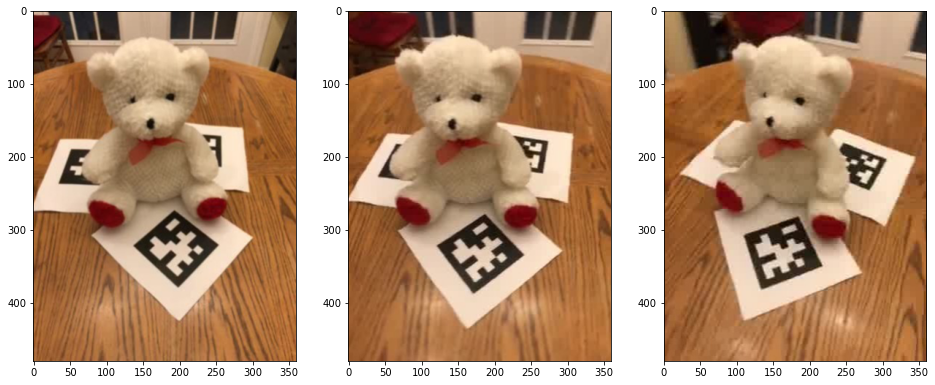

In [7]:
root_path = "./test_dataset/"

tgt_img_path = root_path + '/'.join(data_dicts[0]["image"]["path"].split('/')[1:])

src1_img_path = root_path + '/'.join(data_dicts[6]["image"]["path"].split('/')[1:])
src1_mask_path = root_path + '/'.join(data_dicts[6]["mask"]["path"].split('/')[1:])
print(src1_img_path)
print(src1_mask_path)

src2_img_path = root_path + '/'.join(data_dicts[9]["image"]["path"].split('/')[1:])
src2_mask_path = root_path + '/'.join(data_dicts[9]["mask"]["path"].split('/')[1:])
print(src2_img_path)
print(src2_mask_path)

tgt_img = Image.open(tgt_img_path).resize((360, 480))

src1_img = Image.open(src1_img_path).resize((360, 480))
src1_mask = Image.open(src1_mask_path).resize((360, 480))

src2_img = Image.open(src2_img_path).resize((360, 480))
src2_mask = Image.open(src2_mask_path).resize((360, 480))

print(tgt_img.size, src1_img.size, src2_img.size)
print(src1_mask.size, src2_mask.size)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(tgt_img)
plt.subplot(1, 3, 2)
plt.imshow(src1_img)
plt.subplot(1, 3, 3)
plt.imshow(src2_img)

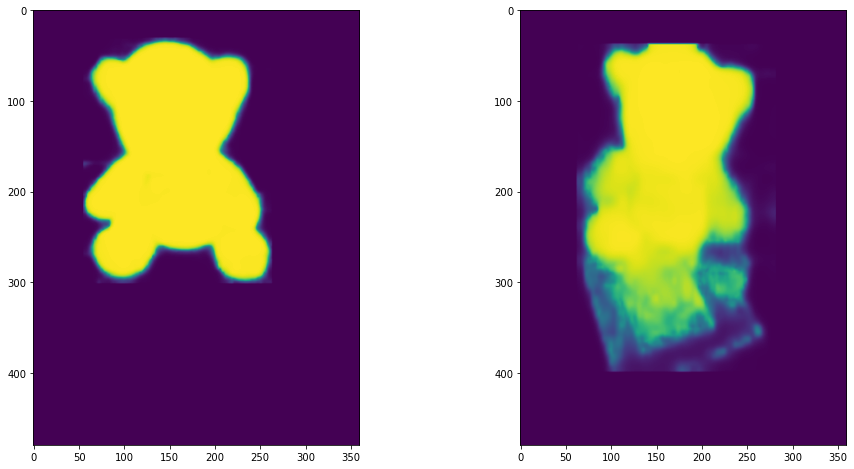

In [8]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(src1_mask)
plt.subplot(1, 2, 2)
plt.imshow(src2_mask)

In [9]:
feature_net = FeatureNet()

to_tensor = transforms.ToTensor()

src1_resnet_feature = feature_net(to_tensor(src1_img).unsqueeze(0))
src2_resnet_feature = feature_net(to_tensor(src2_img).unsqueeze(0))

print(src1_resnet_feature.shape, src2_resnet_feature.shape)

(99, 480, 360)


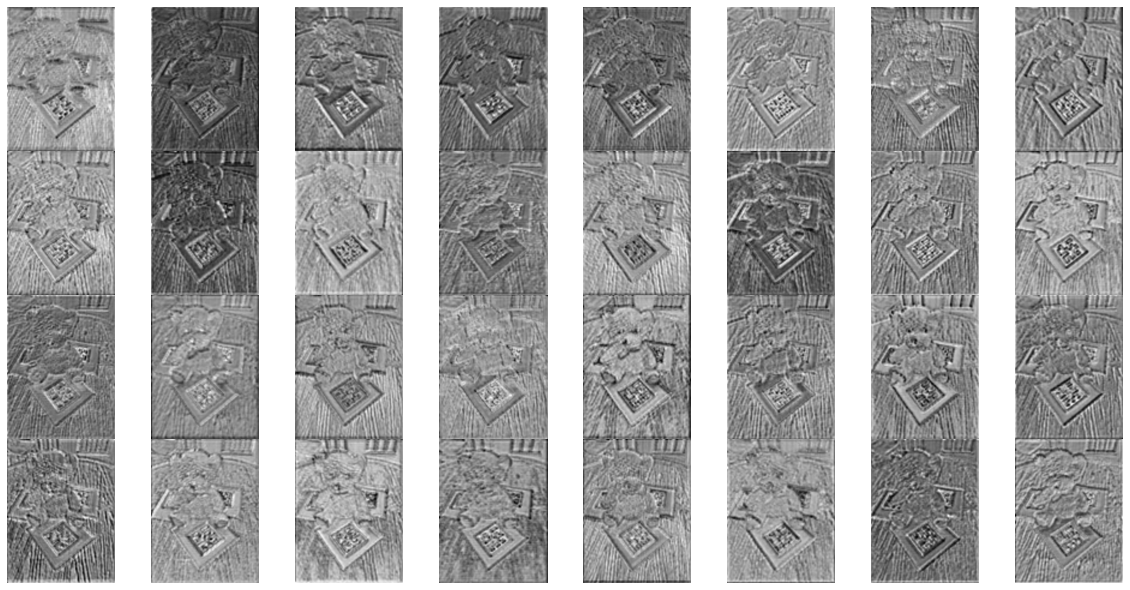

In [22]:
outputs = src1_resnet_feature[0].detach().numpy()
print(outputs.shape)


####################### (layer 1) features
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(outputs.shape[0]):
    if i == 32: # we will visualize only 8x8 blocks from each layer
        break
    plt.subplot(4, 8, i + 1)
    plt.imshow(outputs[i, :, :], cmap='gray')
    plt.axis("off")

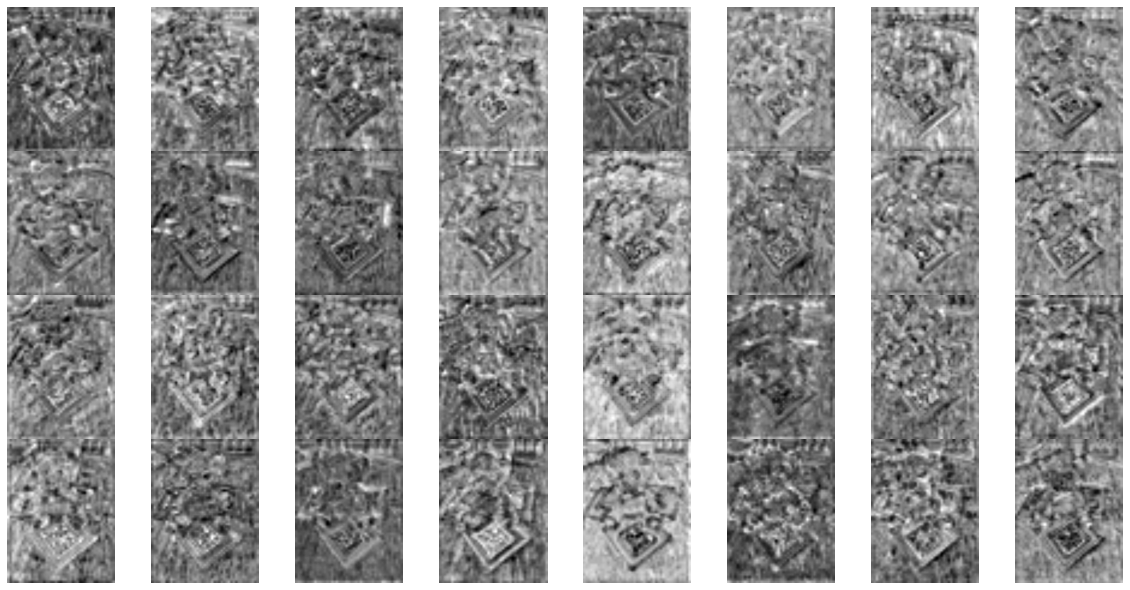

In [23]:
####################### (layer 2) features
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(32, outputs.shape[0]):
    if i == 64: # we will visualize only 8x8 blocks from each layer
        break
    plt.subplot(4, 8, i - 31)
    plt.imshow(outputs[i, :, :], cmap='gray')
    plt.axis("off")

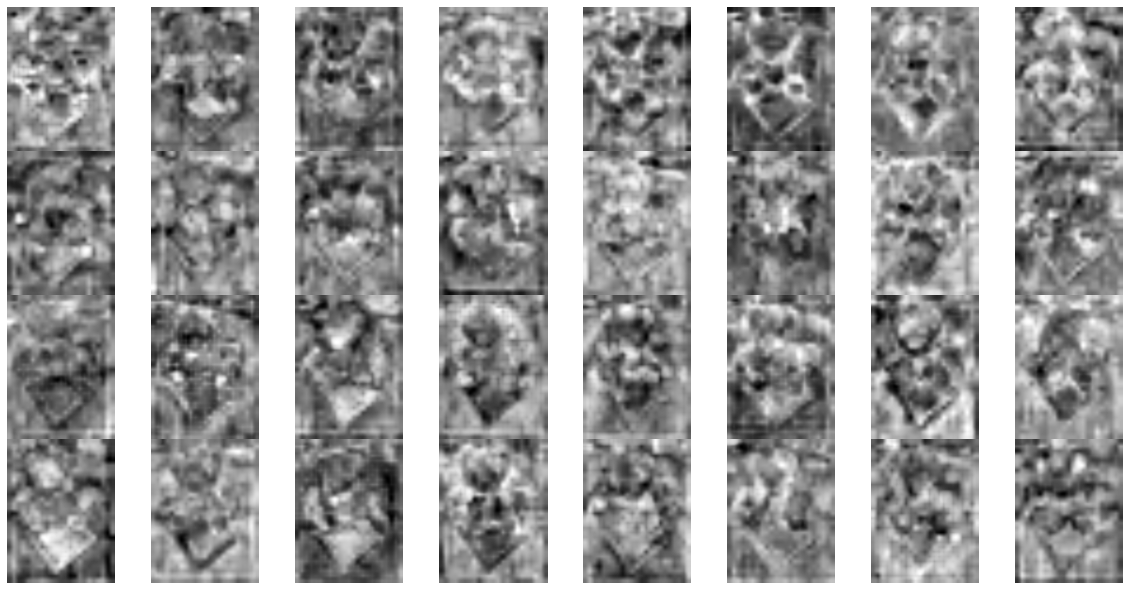

In [24]:
####################### (layer 3) features
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(64, outputs.shape[0]):
    if i == 96: # we will visualize only 8x8 blocks from each layer
        break
    plt.subplot(4, 8, i - 63)
    plt.imshow(outputs[i, :, :], cmap='gray')
    plt.axis("off")

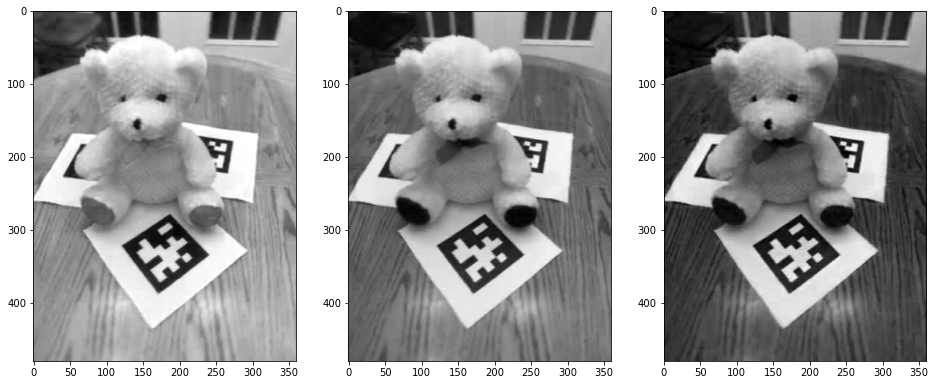

In [25]:
####################### RGB Color
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(outputs[96, :, :], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(outputs[97, :, :], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(outputs[98, :, :], cmap='gray')

In [87]:
intrinsic = torch.eye(4, dtype=torch.float)

viewpoint = data_dicts[0]['viewpoint']
intrinsic[0][0], intrinsic[1][1] = viewpoint['focal_length'][0], viewpoint['focal_length'][1]
intrinsic[0][2], intrinsic[1][2] = viewpoint['principal_point'][0], viewpoint['principal_point'][1]

print("intrinsic : \n", intrinsic)

intrinsic : 
 tensor([[2.1856, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6381, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])


In [88]:
extrinsic = torch.eye(4, dtype=torch.float)

rotation = torch.tensor(viewpoint['R'], dtype=torch.float)
translation = torch.tensor(viewpoint['T'], dtype=torch.float)

print("rotation matrix : \n", rotation, "\nshape : \n", rotation.shape)
print("------------\ntranslation matrix : \n", translation, "\nshape : \n", translation.shape)


extrinsic[:3, :3] = rotation
extrinsic[:3, 3] = translation

print("------------\nextrinsic : \n", extrinsic, "\nshape : \n", extrinsic.shape)

rotation matrix : 
 tensor([[-0.9966,  0.0041,  0.0826],
        [-0.0065, -0.9996, -0.0285],
        [ 0.0825, -0.0289,  0.9962]]) 
shape : 
 torch.Size([3, 3])
------------
translation matrix : 
 tensor([0.2004, 1.2990, 6.4296]) 
shape : 
 torch.Size([3])
------------
extrinsic : 
 tensor([[-9.9657e-01,  4.1219e-03,  8.2644e-02,  2.0044e-01],
        [-6.4938e-03, -9.9957e-01, -2.8452e-02,  1.2990e+00],
        [ 8.2491e-02, -2.8891e-02,  9.9617e-01,  6.4296e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]) 
shape : 
 torch.Size([4, 4])


In [89]:
# w2c = extrinsic
# c2w = torch.inverse(w2c)
c2w = extrinsic

print("camera to world : \n", c2w, "\nshape : \n", c2w.shape)

camera to world : 
 tensor([[-9.9657e-01,  4.1219e-03,  8.2644e-02,  2.0044e-01],
        [-6.4938e-03, -9.9957e-01, -2.8452e-02,  1.2990e+00],
        [ 8.2491e-02, -2.8891e-02,  9.9617e-01,  6.4296e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]) 
shape : 
 torch.Size([4, 4])


In [112]:
x_world = torch.tensor([[10, 10, 20, 1]], dtype=torch.float)

x_camera = (intrinsic.matmul(extrinsic)).matmul(x_world.T)
print(x_camera)

tensor([[-17.6405],
        [-15.2844],
        [ 26.8891],
        [  1.0000]])


In [ ]:
K_inv = torchintrinsic.

In [90]:
c2w_ = c2w.unsqueeze(0)
intrinsic_ = intrinsic.unsqueeze(0)
W = 10
H = 20
u, v = np.meshgrid(np.arange(W), np.arange(H))

# 이미지의 각 row들이 한 줄로 이어붙은 형태로 변환
# (H, W) --> (H*W)
u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]
pixels = torch.from_numpy(pixels)
batched_pixels = pixels.unsqueeze(0).repeat(1, 1, 1)

print(c2w_[:, :3, :3])
print(torch.inverse(intrinsic_[:, :3, :3]))

rays_d = (c2w_[:, :3, :3].bmm(torch.inverse(intrinsic_[:, :3, :3])).bmm(batched_pixels)).transpose(1, 2)
# rays_d = (c2w[:, :3, :3].bmm(torch.inverse(intrinsics[:, :3, :3])).bmm(pixels)).transpose(1, 2)
rays_d = rays_d.reshape(-1, 3)
rays_o = c2w_[:, :3, 3].unsqueeze(1).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)  # B x HW x 3

tensor([[[-0.9966,  0.0041,  0.0826],
         [-0.0065, -0.9996, -0.0285],
         [ 0.0825, -0.0289,  0.9962]]])
tensor([[[0.4575, 0.0000, -0.0000],
         [0.0000, 0.6105, -0.0000],
         [0.0000, 0.0000, 1.0000]]])


In [96]:
pixels[:, :10]

tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [93]:
print(rays_d[:10])
print(rays_o[:10])

tensor([[ 0.0826, -0.0285,  0.9962],
        [-0.3733, -0.0314,  1.0339],
        [-0.8293, -0.0344,  1.0717],
        [-1.2853, -0.0374,  1.1094],
        [-1.7412, -0.0403,  1.1471],
        [-2.1972, -0.0433,  1.1849],
        [-2.6532, -0.0463,  1.2226],
        [-3.1091, -0.0493,  1.2604],
        [-3.5651, -0.0522,  1.2981],
        [-4.0211, -0.0552,  1.3359]])
tensor([[0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296],
        [0.2004, 1.2990, 6.4296]])


In [15]:
# (x, y, z) ---> 3(x, y, z) * 2(sin, cos) * 10 = 60으로 변환
pe = HarmonicEmbedding(10)

pe_test = pe(torch.tensor([0, 0, 1]))
print(pe_test)
print(pe_test.shape)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0998,  0.1987,  0.3894,  0.7174,
         0.9996, -0.0584,  0.1165,  0.2315,  0.4504,  0.8043,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  0.9950,  0.9801,  0.9211,  0.6967, -0.0292, -0.9983,
         0.9932,  0.9728,  0.8928,  0.5942])
torch.Size([60])


In [ ]:
from torch.utils.data import Dataset
import imageio


class CO3Ddataset(Dataset):
    def __init__(self, args, mode, categories=[], **kwargs):
        self.folder_path = os.path.join(args.rootdir, 'CO3D/')
        self.rectify_inplane_rotation = args.rectify_inplane_rotation

        if mode == 'validation':
            mode = 'val'
        assert mode in ['train', 'val', 'test']
        self.mode = mode  # train / test / val w

        self.num_source_views = args.num_source_views

        total_category = os.listdir(self.folder_path)

        if len(categories) > 0:
            if isinstance(categories, str):
                categories = [categories]
        else:
            categories = total_category

        print("loading {} for {}".format(categories, mode))
        
        self.tgt_imgs = []
        self.tgt_poses = []
        self.tgt_intrinsics = []

        for category in categories:
            self.category_path = os.path.join(self.folder_path, category)     # ".../CO3D/teddybear"

            rgb_files, c2ws, intrinsics  = read_category_data(self.category_path)
            
            if self.mode != 'train':
                rgb_files = rgb_files[::self.testskip]
                intrinsics = intrinsics[::self.testskip]
                c2ws = c2ws[::self.testskip]
            self.tgt_imgs.extend(rgb_files)
            self.tgt_poses.extend(c2ws)
            self.tgt_intrinsics.extend(intrinsics)


    def __len__(self):
        return len(self.tgt_imgs)


    def __getitem__(self, idx):
        tgt_img = self.tgt_imgs[idx]
        tgt_pose = self.tgt_poses[idx]
        tgt_intrinsic = self.tgt_intrinsics[idx]
        
        # 선택한 데이터가 속한 category, sequence 이름을 가져온다.
        category, seq_name = tgt_img.split('/')[:-2]   # "teddybear", "38_1655_5016"
        seq_file_path = os.path.join(self.folder_path, category, seq_name, "frame_annotations_file.json")
        # 해당 sequence (=오브젝트)의 모든 img, c2w, intrinsic 정보를 읽어온다. --> 소스뷰로 이용
        src_imgs, src_c2ws, src_intrinsics = read_seq_data(seq_file_path)

        if self.mode == 'train':
            id_render = int(os.path.basename(tgt_img)[:-4].split('_')[1])
            subsample_factor = np.random.choice(np.arange(1, 4), p=[0.3, 0.5, 0.2])
        else:
            id_render = -1
            subsample_factor = 1

        rgb = imageio.imread(tgt_img).astype(np.float32) / 255.
        rgb = rgb[..., [-1]] * rgb[..., :3] + 1 - rgb[..., [-1]]
        img_size = rgb.shape[:2]
        camera = np.concatenate((list(img_size), tgt_intrinsic.flatten(),
                                 tgt_pose.flatten())).astype(np.float32)

        nearest_src_ids = get_nearest_src(tgt_pose,
                                                src_c2ws,
                                                int(self.num_source_views*subsample_factor),
                                                tar_id=id_render,
                                                angular_dist_method='vector')
        nearest_src_ids = np.random.choice(nearest_src_ids, self.num_source_views, replace=False)

        assert id_render not in nearest_src_ids
        # occasionally include input image
        if np.random.choice([0, 1], p=[0.995, 0.005]) and self.mode == 'train':
            nearest_src_ids[np.random.choice(len(nearest_src_ids))] = id_render

        src_rgbs = []
        src_cameras = []
        for id in nearest_src_ids:
            src_rgb = imageio.imread(src_imgs[id]).astype(np.float32) / 255.
            src_rgb = src_rgb[..., [-1]] * src_rgb[..., :3] + 1 - src_rgb[..., [-1]]
            train_pose = src_c2ws[id]
            src_intrinsics_ = src_intrinsics[id]
            if self.rectify_inplane_rotation:
                train_pose, src_rgb = rectify_inplane_rotation(train_pose, tgt_pose, src_rgb)

            src_rgbs.append(src_rgb)
            img_size = src_rgb.shape[:2]
            src_camera = np.concatenate((list(img_size), src_intrinsics_.flatten(),
                                              train_pose.flatten())).astype(np.float32)
            src_cameras.append(src_camera)

        src_rgbs = np.stack(src_rgbs, axis=0)
        src_cameras = np.stack(src_cameras, axis=0)

        near_depth = 2.
        far_depth = 6.

        depth_range = torch.tensor([near_depth, far_depth])

        return {'rgb': torch.from_numpy(rgb[..., :3]),
                'camera': torch.from_numpy(camera),
                'rgb_path': tgt_img,
                'src_rgbs': torch.from_numpy(src_rgbs[..., :3]),
                'src_cameras': torch.from_numpy(src_cameras),
                'depth_range': depth_range,
                }

In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import torch
import torch.nn.functional as F


class Projector():
    def __init__(self, device):
        self.device = device

    def inbound(self, pixel_locations, h, w):
        '''
        픽셀이 이미지 상의 유효한 위치에 놓여 있는지 확인하는 함수.
        param pixel_locations: [..., 2]
        param h: height
        param w: weight
        
        return: mask, bool, [...]
        '''
        return (pixel_locations[..., 0] <= w - 1.) & \
               (pixel_locations[..., 0] >= 0) & \
               (pixel_locations[..., 1] <= h - 1.) &\
               (pixel_locations[..., 1] >= 0)


    def normalize(self, pixel_locations, h, w):
        resize_factor = torch.tensor([w-1., h-1.]).to(pixel_locations.device)[None, None, :]
        normalized_pixel_locations = 2 * pixel_locations / resize_factor - 1.  # [n_views, n_points, 2]
        
        return normalized_pixel_locations


    def compute_projections(self, xyz, train_cameras):
        '''
        3D 포인트를 해당 카메라의 이미지 스페이스로 프로젝션하는 함수
        param xyz: [..., 3]
        param train_cameras: [n_views, 34], 34 = img_size(2) + intrinsics(16) + extrinsics(16)
        
        return: pixel locations [..., 2], mask [...]
        '''
        original_shape = xyz.shape[:2]
        xyz = xyz.reshape(-1, 3)
        num_views = len(train_cameras)
        train_intrinsics = train_cameras[:, 2:18].reshape(-1, 4, 4)  # [n_views, 4, 4]
        train_poses = train_cameras[:, -16:].reshape(-1, 4, 4)  # [n_views, 4, 4]
        xyz_h = torch.cat([xyz, torch.ones_like(xyz[..., :1])], dim=-1)  # [n_points, 4]
        projections = train_intrinsics.bmm(torch.inverse(train_poses)) \
            .bmm(xyz_h.t()[None, ...].repeat(num_views, 1, 1))  # [n_views, 4, n_points]
        projections = projections.permute(0, 2, 1)  # [n_views, n_points, 4]
        pixel_locations = projections[..., :2] / torch.clamp(projections[..., 2:3], min=1e-8)  # [n_views, n_points, 2]
        pixel_locations = torch.clamp(pixel_locations, min=-1e6, max=1e6)
        mask = projections[..., 2] > 0   # a point is invalid if behind the camera
        
        return pixel_locations.reshape((num_views, ) + original_shape + (2, )), \
               mask.reshape((num_views, ) + original_shape)


    def compute_angle(self, xyz, query_camera, train_cameras):
        '''
        param xyz: [..., 3]
        param query_camera: 타겟 카메라 [34, ]
        param train_cameras: 소스 카메라 [n_views, 34]
        
        return: [n_views, ..., 4]; The first 3 channels are unit-length vector of the difference between
        query and target ray directions, the last channel is the inner product of the two directions.
        '''
        original_shape = xyz.shape[:2]
        xyz = xyz.reshape(-1, 3)
        
        train_poses = train_cameras[:, -16:].reshape(-1, 4, 4)  # [n_views, 4, 4]
        num_views = len(train_poses)

        # 타겟 포즈도 소스 개수만큼 복사.
        query_pose = query_camera[-16:].reshape(-1, 4, 4).repeat(num_views, 1, 1)  # [n_views, 4, 4]

        ray2tar_pose = (query_pose[:, :3, 3].unsqueeze(1) - xyz.unsqueeze(0))
        ray2tar_pose /= (torch.norm(ray2tar_pose, dim=-1, keepdim=True) + 1e-6)
        ray2train_pose = (train_poses[:, :3, 3].unsqueeze(1) - xyz.unsqueeze(0))
        ray2train_pose /= (torch.norm(ray2train_pose, dim=-1, keepdim=True) + 1e-6)
        ray_diff = ray2tar_pose - ray2train_pose
        ray_diff_norm = torch.norm(ray_diff, dim=-1, keepdim=True)
        ray_diff_dot = torch.sum(ray2tar_pose * ray2train_pose, dim=-1, keepdim=True)
        ray_diff_direction = ray_diff / torch.clamp(ray_diff_norm, min=1e-6)
        ray_diff = torch.cat([ray_diff_direction, ray_diff_dot], dim=-1)
        ray_diff = ray_diff.reshape((num_views, ) + original_shape + (4, ))

        return ray_diff


    def compute(self,  xyz, query_camera, train_imgs, train_cameras, featmaps):
        '''
        :param xyz: [n_rays, n_samples, 3]
        :param query_camera: [1, 34], 34 = img_size(2) + intrinsics(16) + extrinsics(16)
        :param train_imgs: [1, n_views, h, w, 3]
        :param train_cameras: [1, n_views, 34]
        :param featmaps: [n_views, d, h, w]
        :return: rgb_feat_sampled: [n_rays, n_samples, 3+n_feat],
                 ray_diff: [n_rays, n_samples, 4],
                 mask: [n_rays, n_samples, 1]
        '''
        assert (train_imgs.shape[0] == 1) \
               and (train_cameras.shape[0] == 1) \
               and (query_camera.shape[0] == 1), 'only support batch_size=1 for now'

        train_imgs = train_imgs.squeeze(0)  # [n_views, h, w, 3]
        train_cameras = train_cameras.squeeze(0)  # [n_views, 34]
        query_camera = query_camera.squeeze(0)  # [34, ]

        train_imgs = train_imgs.permute(0, 3, 1, 2)  # [n_views, 3, h, w]

        h, w = train_cameras[0][:2]

        # compute the projection of the query points to each reference image
        pixel_locations, mask_in_front = self.compute_projections(xyz, train_cameras)
        normalized_pixel_locations = self.normalize(pixel_locations, h, w)   # [n_views, n_rays, n_samples, 2]

        # rgb sampling
        rgbs_sampled = F.grid_sample(train_imgs, normalized_pixel_locations, align_corners=True)
        rgb_sampled = rgbs_sampled.permute(2, 3, 0, 1)  # [n_rays, n_samples, n_views, 3]

        # deep feature sampling
        feat_sampled = F.grid_sample(featmaps, normalized_pixel_locations, align_corners=True)
        feat_sampled = feat_sampled.permute(2, 3, 0, 1)  # [n_rays, n_samples, n_views, d]
        rgb_feat_sampled = torch.cat([rgb_sampled, feat_sampled], dim=-1)   # [n_rays, n_samples, n_views, d+3]

        # mask
        inbound = self.inbound(pixel_locations, h, w)
        ray_diff = self.compute_angle(xyz, query_camera, train_cameras)
        ray_diff = ray_diff.permute(1, 2, 0, 3)
        mask = (inbound * mask_in_front).float().permute(1, 2, 0)[..., None]   # [n_rays, n_samples, n_views, 1]

        return rgb_feat_sampled, ray_diff, mask

In [ ]:
ray_sampler = RaySampler(train_data, device)

In [ ]:
# 타겟 이미지 내에서 랜덤으로 픽셀 샘플링
def sample_random_pixel(H, W, N_rand, sample_mode, center_ratio=0.8):
    rng = np.random.RandomState(234)

    if sample_mode == 'center':
        border_H = int(H * (1 - center_ratio) / 2.)
        border_W = int(W * (1 - center_ratio) / 2.)

        # pixel coordinates
        u, v = np.meshgrid(np.arange(border_H, H - border_H),
                            np.arange(border_W, W - border_W))
        u = u.reshape(-1)
        v = v.reshape(-1)

        select_inds = rng.choice(u.shape[0], size=(N_rand,), replace=False)
        select_inds = v[select_inds] + W * u[select_inds]

    elif sample_mode == 'uniform':
        # Random from one image
        select_inds = rng.choice(H*W, size=(N_rand,), replace=False)
    else:
        raise Exception("unknown sample mode!")

    return select_inds

In [ ]:
random_pixels = sample_random_pixel(500, 500, 800, "center")
print(len(random_pixels), '\n', random_pixels[:10])

In [ ]:
# 타겟 이미지의 각 픽셀마다 rays_o, rays_d를 구함
def get_rays(H, W, intrinsics, c2w, batch_size=1, render_stride=1):
    '''
    param H: image height
    param W: image width
    param intrinsics: 4 by 4 intrinsic matrix
    param c2w: 4 by 4 camera to world extrinsic matrix
    
    return: rays_o, rays_d
    '''
    # u --> x 인덱싱
    # v --> y 인덱싱
    u, v = np.meshgrid(np.arange(W)[::render_stride], np.arange(H)[::render_stride])

    # 이미지의 각 row들이 이어붙은 형태로 변환
    # (H, W) --> (H*W)
    u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
    v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

    pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]
    pixels = torch.from_numpy(pixels)
    print(pixels.shape)
    batched_pixels = pixels.unsqueeze(0).repeat(batch_size, 1, 1)

    # bmm : batch matrix-matrix product 
    # [B, N, M] tensor * [B, M, P] tensor >>> [B, N, P]
    rays_d = (c2w[:, :3, :3].bmm(torch.inverse(intrinsics[:, :3, :3])).bmm(batched_pixels)).transpose(1, 2)
    # rays_d = (c2w[:, :3, :3].bmm(torch.inverse(intrinsics[:, :3, :3])).bmm(pixels)).transpose(1, 2)
    rays_d = rays_d.reshape(-1, 3)
    rays_o = c2w[:, :3, 3].unsqueeze(1).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)  # B x HW x 3
    
    return rays_o, rays_d

In [ ]:
rays_o, rays_d = get_rays(img1.height, img1.width, intrinsic.unsqueeze(0), c2w.unsqueeze(0))

print(rays_o.shape, rays_d.shape)

In [150]:
def sample_along_camera_ray(ray_o, ray_d, depth_range,
                            N_samples,
                            inv_uniform=False,
                            det=False):
    '''
    param ray_o: scene coordinate system에서 ray의 원점 : [N_rays, 3]
    param ray_d: scene coordinate system에서 ray의 direction vector : [N_rays, 3]
    param depth_range: [near_depth, far_depth]
    param inv_uniform: if True, uniformly sampling inverse depth
    param det: if True, will perform deterministic sampling
    
    return: tensor of shape [N_rays, N_samples, 3]
    '''
    # 샘플들은 [near_depth, far_depth] 범위 안에 있어야 함.
    # assume the nearest possible depth is at least (min_ratio * depth)
    near_depth_value = depth_range[0, 0]
    far_depth_value = depth_range[0, 1]
    assert near_depth_value > 0 and far_depth_value > 0 and far_depth_value > near_depth_value

    near_depth = near_depth_value * torch.ones_like(ray_d[..., 0])
    far_depth = far_depth_value * torch.ones_like(ray_d[..., 0])

    if inv_uniform:
        start = 1. / near_depth     # [N_rays,]
        step = (1. / far_depth - start) / (N_samples-1)
        inv_z_vals = torch.stack([start+i*step for i in range(N_samples)], dim=1)  # [N_rays, N_samples]
        z_vals = 1. / inv_z_vals
    else:
        start = near_depth
        step = (far_depth - near_depth) / (N_samples-1)
        z_vals = torch.stack([start+i*step for i in range(N_samples)], dim=1)  # [N_rays, N_samples]

    if not det:
        # get intervals between samples
        mids = .5 * (z_vals[:, 1:] + z_vals[:, :-1])
        upper = torch.cat([mids, z_vals[:, -1:]], dim=-1)
        lower = torch.cat([z_vals[:, 0:1], mids], dim=-1)
        # uniform samples in those intervals
        t_rand = torch.rand_like(z_vals)
        z_vals = lower + (upper - lower) * t_rand   # [N_rays, N_samples]

    ray_d = ray_d.unsqueeze(1).repeat(1, N_samples, 1)  # [N_rays, N_samples, 3]
    ray_o = ray_o.unsqueeze(1).repeat(1, N_samples, 1)

    # 샘플 포인트 위치를 계산.
    # ray의 원점으로부터 ray의 방향으로 z_val만큼 전진한 것.
    pts = z_vals.unsqueeze(2) * ray_d + ray_o       # [N_rays, N_samples, 3]
    
    return pts, z_vals

In [145]:
ray_d = rays_d.clone()
ray_o = rays_o.clone()

print(ray_d.shape, ray_o.shape)

torch.Size([171961, 3]) torch.Size([171961, 3])


In [154]:
depth_range = torch.tensor([[0.1, 3.0]])
N_samples = 20

pts, z_vals = sample_along_camera_ray(ray_o, ray_d, depth_range, N_samples)

In [155]:
print(pts.shape)
print(z_vals.shape)

torch.Size([171961, 20, 3])
torch.Size([171961, 20])


In [159]:
# 400번째 ray에서의 samples
pts[400]

tensor([[ -1.4153,  -0.0613,   0.1650],
        [ -1.5882,  -0.0688,   0.1851],
        [ -3.4004,  -0.1472,   0.3963],
        [ -5.2240,  -0.2261,   0.6089],
        [ -6.6318,  -0.2871,   0.7730],
        [ -7.8613,  -0.3403,   0.9163],
        [ -8.7938,  -0.3807,   1.0250],
        [-10.1739,  -0.4404,   1.1858],
        [-10.7546,  -0.4656,   1.2535],
        [-12.8424,  -0.5560,   1.4969],
        [-13.9064,  -0.6020,   1.6209],
        [-15.5691,  -0.6740,   1.8147],
        [-16.1829,  -0.7006,   1.8862],
        [-17.7843,  -0.7699,   2.0729],
        [-18.9395,  -0.8199,   2.2075],
        [-20.2334,  -0.8759,   2.3583],
        [-21.3119,  -0.9226,   2.4840],
        [-22.5580,  -0.9765,   2.6293],
        [-24.7361,  -1.0708,   2.8831],
        [-25.7066,  -1.1128,   2.9963]])